# VAMPNets on Alanine Dipeptide

This example we study the Alanine Dipeptide molecule. Alanine Dipeptide is an example for a small peptide exhibiting rare-events in solution at room temperature. The $\phi$ and $\psi$ dihedral angles of the molecule have been identified as the two relevant coordinates for the slowest kinteic processes of the system under equilibrium conditions. 

Here we seek to recover these relevant coordinates from $(x,y,z)$ atom position data using VAMPNets. To this end, we require a working installation of [PyTorch](https://pytorch.org/) as well as [mdshare](https://markovmodel.github.io/mdshare/) to obtain the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import mdshare  # for trajectory data

from tqdm.notebook import tqdm  # progress bar

First, we set up the device. If available, we use CUDA.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(12)

print(f"Using device {device}")

Using device cuda


Obtain the data via mdshare:

In [3]:
ala_coords_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-heavy-atom-positions.npz", working_directory="data"
)
with np.load(ala_coords_file) as fh:
    data = [fh[f"arr_{i}"].astype(np.float32) for i in range(3)]

dihedral_file = mdshare.fetch(
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz", working_directory="data"
)
with np.load(dihedral_file) as fh:
    dihedral = [fh[f"arr_{i}"] for i in range(3)]

Since the dynamics of the molecule are completely described by its position in the dihedral plane, we can use these two variables to visualize the state population.

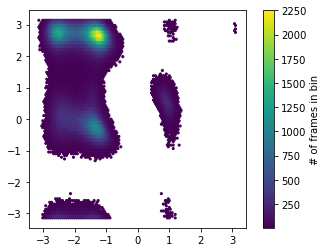

In [4]:
f, ax = plt.subplots(1, 1)
hb = ax.hexbin(*np.concatenate(dihedral).T, mincnt=5)
ax.set_aspect('equal')
cb = f.colorbar(hb, ax=ax)
cb.set_label('# of frames in bin')

Let's define the dataset that we use for training and validation. We use a lagtime $\tau=1$.

In [5]:
from deeptime.util.data import TrajectoryDataset, TrajectoriesDataset

dataset = TrajectoriesDataset.from_numpy(1, data)

Now we split the data into training and validation set.

In [6]:
n_val = int(len(dataset)*.1)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])

Now we can set up the VAMPNet lobe(s).

In [7]:
lobe = nn.Sequential(
    nn.BatchNorm1d(data[0].shape[1]),
    nn.Linear(data[0].shape[1], 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 20), nn.ELU(),
    nn.Linear(20, 6),
    nn.Softmax(dim=1)  # obtain fuzzy probability distribution over output states
)

lobe = lobe.to(device=device)
print(lobe)

Sequential(
  (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=30, out_features=20, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=20, out_features=20, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=20, out_features=20, bias=True)
  (8): ELU(alpha=1.0)
  (9): Linear(in_features=20, out_features=20, bias=True)
  (10): ELU(alpha=1.0)
  (11): Linear(in_features=20, out_features=6, bias=True)
  (12): Softmax(dim=1)
)


With the lobe defined, we can create a VAMPNet estimator.

In [8]:
from deeptime.decomposition.deep import VAMPNet

vampnet = VAMPNet(lobe=lobe, learning_rate=5e-3, device=device)

In order to train the VAMPNet transformations, we set up data loaders.

In [9]:
from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=10000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

And train!

In [10]:
model = vampnet.fit(loader_train, n_epochs=30,
                    validation_loader=loader_val, progress=tqdm).fetch_model()

VAMPNet epoch:   0%|          | 0/30 [00:00<?, ?it/s]

We can visualize the progression of train and validation scores.

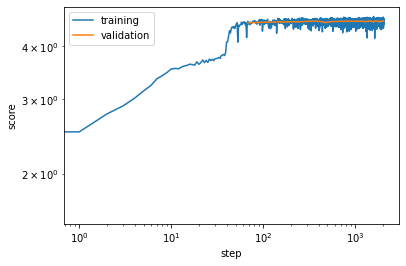

In [11]:
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();

Given the trained model, we can transform our data and visualize the state probability in the $(\phi, \psi)$ plane.

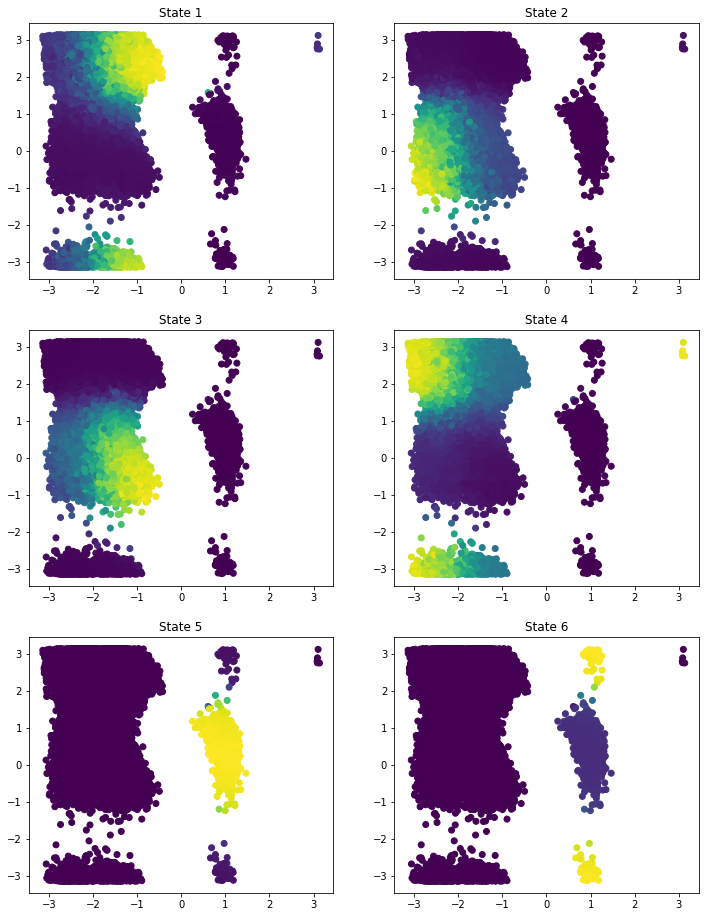

In [12]:
state_probabilities = model.transform(data[0])

f, axes = plt.subplots(3, 2, figsize=(12, 16))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(*dihedral[0][::5].T, c=state_probabilities[..., i][::5])
    ax.set_title(f'State {i+1}')

One can also have a look at the assignment probability ranges that are produced by the forward lobe

In [13]:
state_probabilities = model.transform(data[0])
for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities, axis=0), 
                                      np.max(state_probabilities, axis=0))):
    print(f"State {ix+1}: [{mini}, {maxi}]")

State 1: [6.8025465225218795e-06, 0.6695964336395264]
State 2: [3.1106631013244623e-06, 0.7277129888534546]
State 3: [5.470411451824475e-06, 0.8271698355674744]
State 4: [1.245184012077516e-05, 0.9025066494941711]
State 5: [6.952666444703937e-05, 0.8756899833679199]
State 6: [8.31223042041529e-06, 0.9684250354766846]


as well as cluster in the transformed space and assign each frame to its cluster center by taking the crisp assignment. Note that this step could also be performed by clustering with a potentially larger number of clusters.

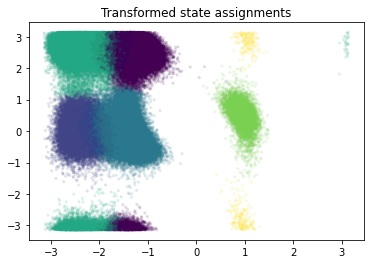

In [14]:
assignments = state_probabilities.argmax(1)
plt.scatter(*dihedral[0].T, c=assignments, s=5, alpha=.1)
plt.title('Transformed state assignments');

With the transform we can obtain a VAMP model.

In [15]:
from deeptime.decomposition import VAMP

vamp_estimator = VAMP(lagtime=10, observable_transform=model)
vamp = vamp_estimator.fit(data).fetch_model()
print(f"VAMP-2 score under lag 10: s = {vamp.score(2).round(2)}")

VAMP-2 score under lag 10: s = 3.28


We may also evaluate the implied timescales to get an indication under which lagtime the data behaves Markovian, i.e., the region in which the implied timescales are flat. The timescales under the gray area are faster than the lagtime, meaning the corresponding processes have decayed and are no longer resolved by the model.

  0%|          | 0/9 [00:00<?, ?it/s]

Text(0, 0.5, 'timescale')

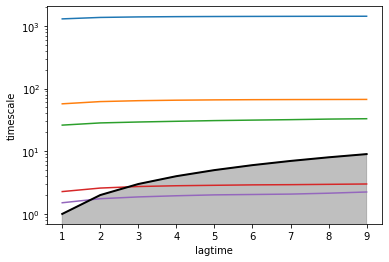

In [16]:
from deeptime.util.validation import implied_timescales, ck_test
from deeptime.plots import plot_implied_timescales, plot_ck_test

lagtimes = np.arange(1, 10, dtype=np.int32)
vamp_models = [VAMP(lagtime=lag, observable_transform=model).fit_fetch(data) for lag in tqdm(lagtimes)]

ax = plot_implied_timescales(implied_timescales(vamp_models))
ax.set_yscale('log')
ax.set_xlabel('lagtime')
ax.set_ylabel('timescale')

We may also perform a Chapman-Kolmogorov test. It is a relaxation experiment which, starting from each individual major process, checks how it evolves with respect to lagtime vs. estimating a new model at higher lagtime. If they show good agreement, this further validates that the data behaves Markovian at the chosen lagtime.

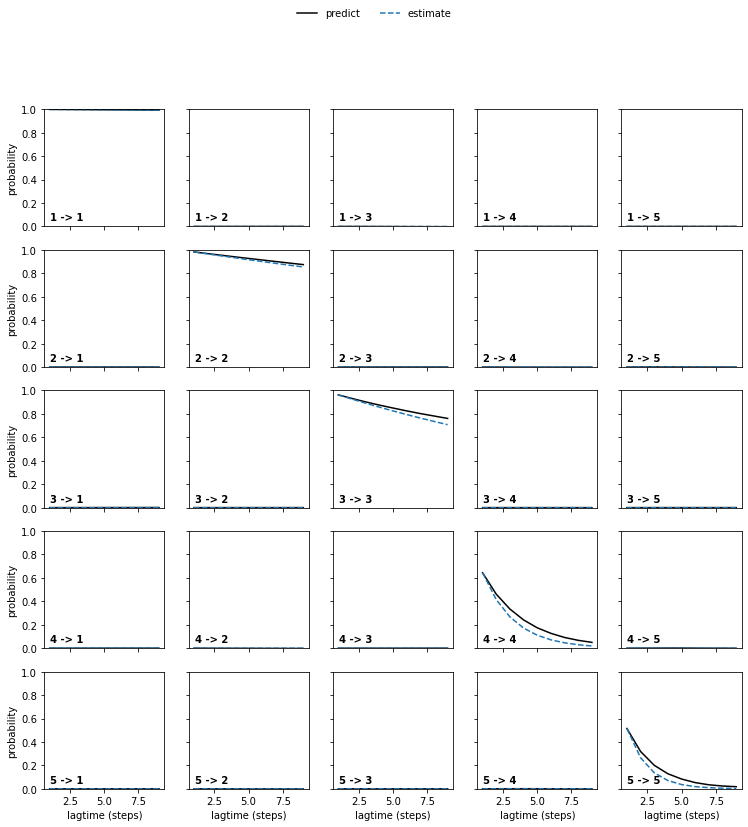

In [17]:
plot_ck_test(vamp_models[0].ck_test(vamp_models));

Based on these observations we pick a VAMP model with lagtime 2.

In [18]:
vamp = vamp_models[1]
print(vamp.lagtime)

2


We may also estimate a Bayesian MSM as part of the 'usual' pipeline:

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

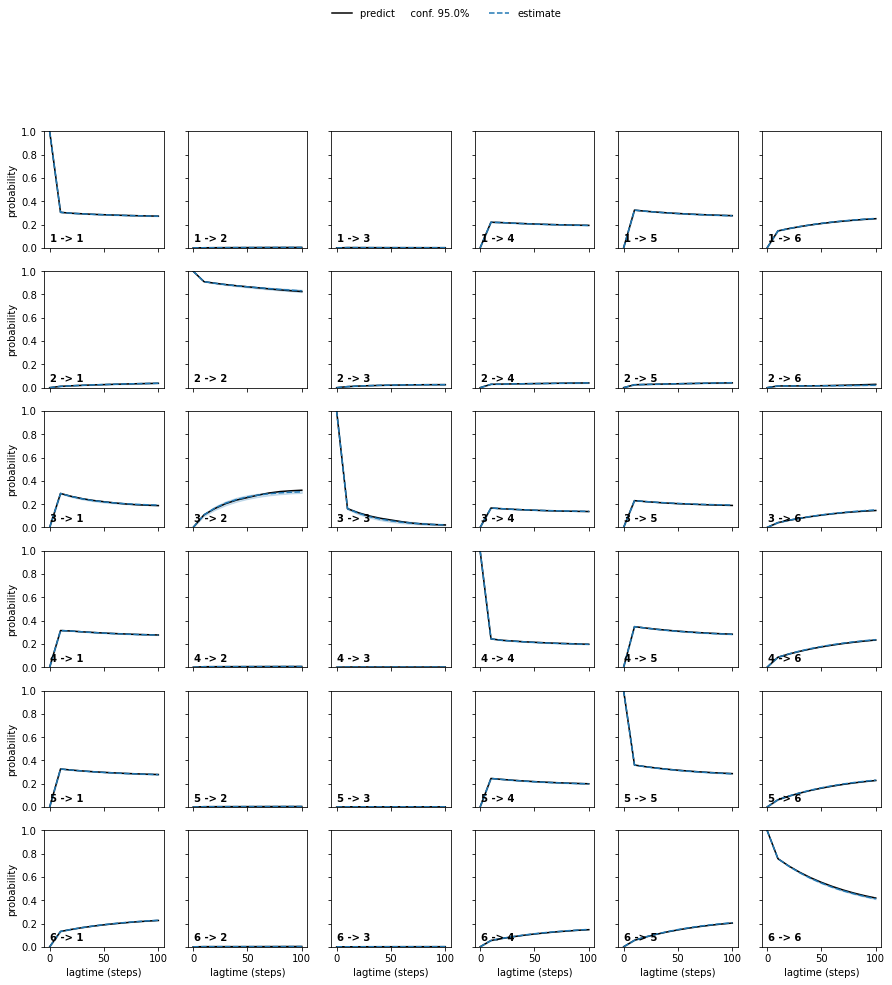

In [19]:
from deeptime.clustering import KMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM

projections = [vamp.transform(traj) for traj in data]
cluster = KMeans(80, progress=tqdm).fit_fetch(projections)
dtrajs = [cluster.transform(x) for x in projections]

bmsms = [BayesianMSM(lagtime=lag).fit_fetch(dtrajs) for lag in tqdm([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])]
ck_test = bmsms[0].ck_test(bmsms, 6)
plot_ck_test(ck_test);

Or work with crisp assignments directly:

  0%|          | 0/10 [00:00<?, ?it/s]

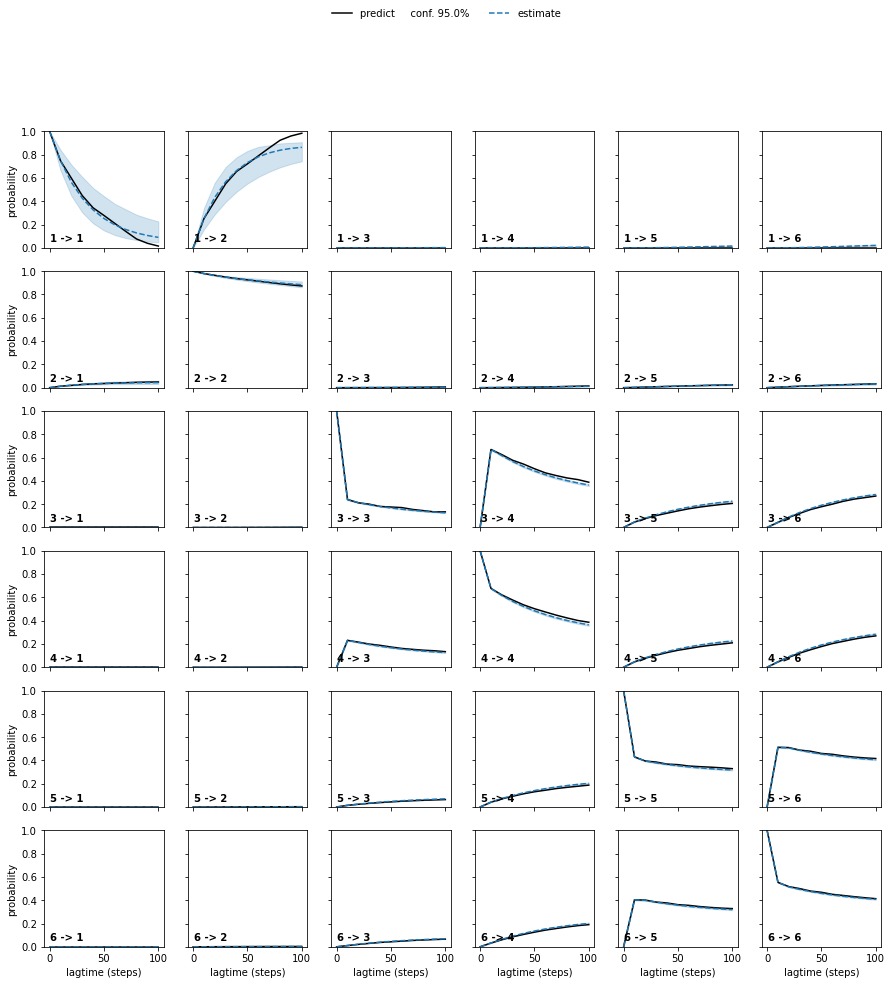

In [20]:
bmsms = [BayesianMSM(lagtime=lag).fit_fetch(assignments) for lag in tqdm([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])]
ck_test = bmsms[0].ck_test(bmsms, 6)
plot_ck_test(ck_test);